## Importing Libraries and Loading Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# torch.cuda.empty_cache()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

!cp drive/MyDrive/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/cyberbullying-classification

!unzip cyberbullying-classification.zip

 71% 2.00M/2.82M [00:01<00:00, 2.19MB/s]
100% 2.82M/2.82M [00:01<00:00, 2.57MB/s]
Archive:  cyberbullying-classification.zip
  inflating: cyberbullying_tweets.csv  


In [ ]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

!pip install -q git+https://github.com/huggingface/transformers.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.8 MB/s eta 0:00:00


## Importing and Model Configuration

In [ ]:
import io
import os
import torch
import pandas as pd
from numpy.random import RandomState
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


set_seed(123)

epochs = 4

batch_size = 32

max_length = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = 'gpt2'

labels_ids = {'religion': 0, 'age': 1, 'gender': 2, 'ethnicity': 3, 'not_cyberbullying': 4, 'other_cyberbullying': 5}

n_labels = len(labels_ids)

In [ ]:
class CyberbullyingDataset(Dataset):

  def __init__(self, df, use_tokenizer):

    self.texts = df['tweet_text'].tolist()
    self.labels = df['cyberbullying_type'].tolist()

    for text in self.texts:
      text = fix_text(text)

    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder
        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})
        return inputs

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Loading configuration...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuration...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')
rng = RandomState()

train = df.sample(frac=0.7, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
train_dataset = CyberbullyingDataset(df=train,
                               use_tokenizer=tokenizer)e
print('Created `train_dataset` with %d examples!'%len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))
print()
print('Dealing with Validation...')
valid_dataset =  CyberbullyingDataset(df=test,
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                              collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealing with Train...
Created `train_dataset` with 33384 examples!
Created `train_dataloader` with 1044 batches!

Dealing with Validation...
Created `valid_dataset` with 14308 examples!
Created `eval_dataloader` with 448 batches!


## Training and Testing Model

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.99215 - val_loss: 0.64785 - train_acc: 0.63465 - valid_acc: 0.74818


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.62238 - val_loss: 0.66423 - train_acc: 0.75548 - valid_acc: 0.76097


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.68795 - val_loss: 0.62202 - train_acc: 0.73982 - valid_acc: 0.76307


Training on batches...


  0%|          | 0/1044 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/448 [00:00<?, ?it/s]

  train_loss: 0.58332 - val_loss: 0.59636 - train_acc: 0.77148 - valid_acc: 0.76873



/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


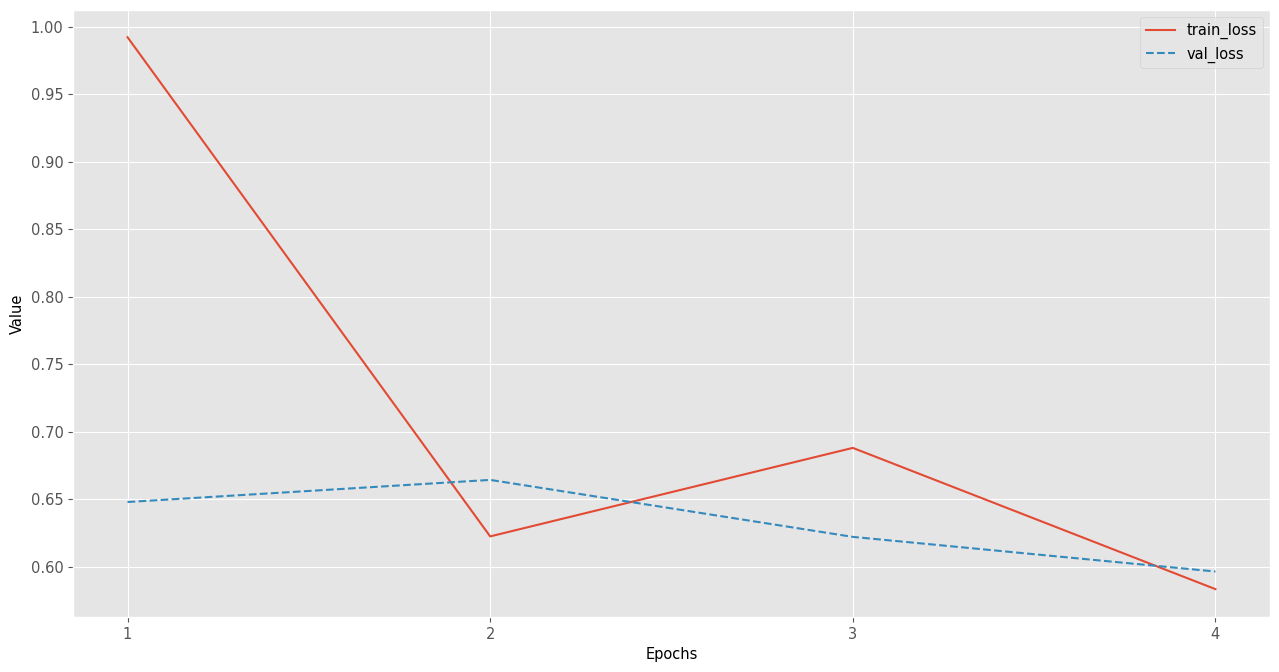

/usr/local/lib/python3.9/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


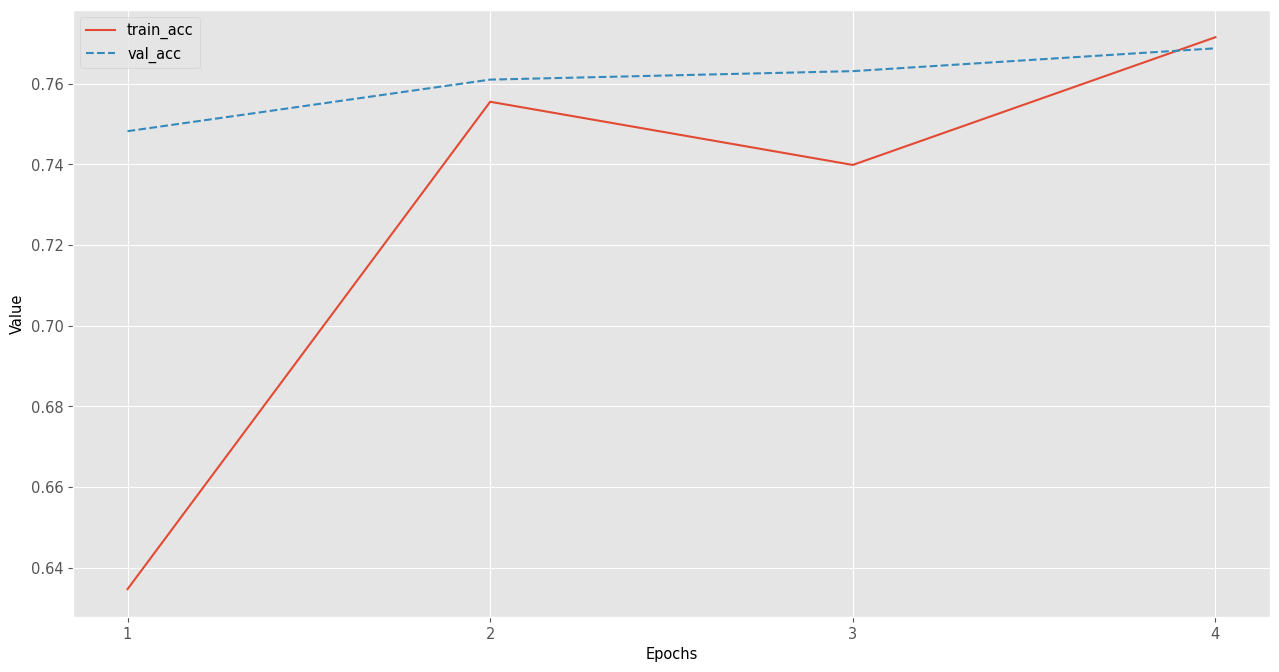

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/448 [00:00<?, ?it/s]

Accuracy: 76.87%
                     precision    recall  f1-score   support

           religion       0.88      0.92      0.90      2449
                age       0.89      0.89      0.89      2365
             gender       0.81      0.78      0.80      2433
          ethnicity       0.90      0.88      0.89      2360
  not_cyberbullying       0.56      0.48      0.52      2329
other_cyberbullying       0.57      0.65      0.61      2372

           accuracy                           0.77     14308
          macro avg       0.77      0.77      0.77     14308
       weighted avg       0.77      0.77      0.77     14308

Normalized confusion matrix


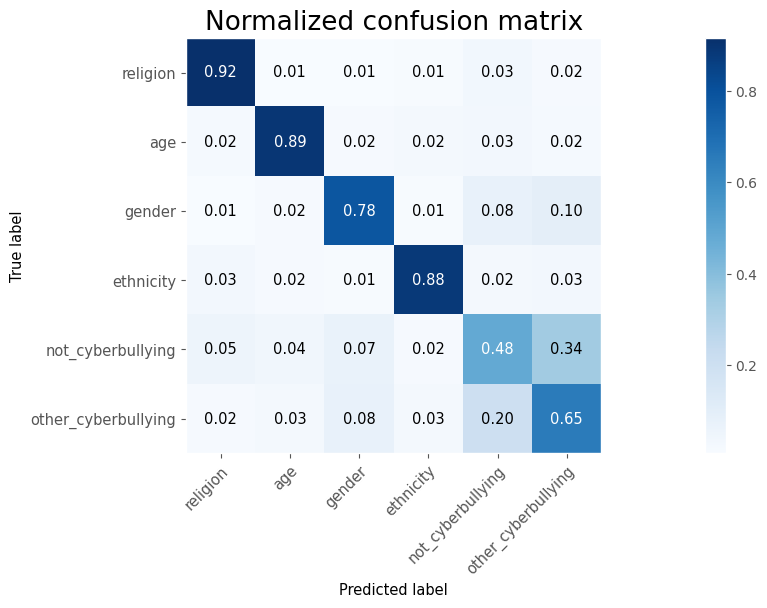

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

acc = accuracy_score(true_labels, predictions_labels) * 100
print("Accuracy: %.2f%%" % (acc))

evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );